## NLP: lda_model y lsi_model

*Gina Martinez*


In [1]:
# librerías para procesar
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
url= "https://raw.githubusercontent.com/Fabian830348/Bases_Datos/master/base_LDA.json"

* Considere el siguiente conjunto de documentos ***obtener los temas (Topics) de una serie de artículos (noticias)*** que está etiquetados con un tema (el corpus tiene 20 temas)

In [3]:
df = pd.read_json(url)
datos = df.copy()
df


,content,target,target_names
2362,From: brown@ftms.UUCP (Vidiot)\nSubject: Re: p...,5,comp.windows.x
6854,From: markm@bigfoot.sps.mot.com (Mark Monninge...,7,rec.autos
11123,From: fmsalvat@eos.ncsu.edu (FRANK MICHAE SALV...,10,rec.sport.hockey
7235,From: erics@netcom.com (Eric Smith)\nSubject: ...,9,rec.sport.baseball
10824,From: avg@rodan.UU.NET (Vadim Antonov)\nSubjec...,11,sci.crypt
...,...,...,...
9595,From: asket@acad2.alaska.edu\nSubject: When is...,15,soc.religion.christian
9554,From: dudek@acsu.buffalo.edu (The Cybard)\nSub...,2,comp.os.ms-windows.misc
5969,From: HoffmanE@space1.spacenet.jhuapl.edu (Hof...,14,sci.space
8239,From: katkere@krusty.eecs.umich.edu (Arun Katk...,1,comp.graphics


In [4]:
df.groupby(['target', 'target_names']).count()

,,content
target,target_names,
0,alt.atheism,92
1,comp.graphics,120
2,comp.os.ms-windows.misc,122
3,comp.sys.ibm.pc.hardware,138
4,comp.sys.mac.hardware,122
5,comp.windows.x,135
6,misc.forsale,145
7,rec.autos,137
8,rec.motorcycles,118


4. Normalización usando spaCy

In [5]:
#!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

2023-04-20 19:24:48.757889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 19:24:50.481293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import spacy
import re
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

In [7]:
df_clean = df[df["content"].isna() == False] # quitamos valores NA

Normalizamos con las condiciones indicadas

In [8]:

nlp = spacy.load('en_core_web_sm')

def normalize(text):
    text = re.sub(r'\S+@\S+', '', text)
    
    doc= nlp(text)
    normalized_tokens = []
    for token in doc:
        if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
            if len(token.text) > 3 and len(token.text) < 12:
        # Si el token no es una stopword y no es un signo de puntuación
                if not token.is_stop and not token.is_punct:

                    # Lemmatizamos el token
                    normalized = token.lemma_
                    # Convertimos el lema a minúsculas
                    normalized = normalized.lower()
                    # Eliminamos los caracteres especiales
                    normalized = re.sub(
                        r'[^a-zA-ZñÑáéíóúÁÉÍÓÚ]', '', normalized)
                    if len(normalized) > 3 and len(normalized) < 12:
                        normalized_tokens.append(normalized)
    # Unimos los tokens normalizados en un solo string
    normalized_text = " ".join(normalized_tokens)
    return normalized_text


correo_clean = []
for correo in df_clean["content"]:
    correo_clean.append(normalize(correo))

In [9]:
correo_clean

['subject problem xvertext package reply line article write need future display rotate text notice xvertext package look good slight problem assume font load font difficult split function interface routine font xfontstruct think author case plan email address bounce current maintainer xvertext mail address mention know backwards real address state',
 'subject auto posting host reply line article write chemist come substitute hear people stand rake retrofit automobile mount organize campaign squash substitute existence altogether shaky technical ground good outright wrong know substitute exist sound carb company',
 'subject originator reply line article write little prediction count devil score goal tonight streak secondly count point game prediciton penguins islander capital prediction heed consider predict proper matchup maybe forecast weather instead',
 'subject keyword line guest line write single team pennant division join',
 'subject invent line host article write divide escrow ag

Crear del diccionario y la bolsa de palabras


In [10]:
# para imprimir de otra forma
from pprint import pprint
# diccionario de gensim
from gensim import corpora
from collections import defaultdict

# Tokenizamos
documents = [word.split() for word in correo_clean]

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in documents:
    for token in doc:
        frequency[token] += 1
        
documents = [[token for token in doc] for doc in documents]
dictionary = corpora.Dictionary(documents)
print('Diccionario:')
pprint(dictionary.token2id)



Streaming output truncated to the last 5000 lines.
 'pottage': 7553,
 'pouch': 14331,
 'pound': 169,
 'poundal': 170,
 'pour': 9819,
 'poverty': 9266,
 'powder': 7248,
 'poweful': 11004,
 'power': 813,
 'powerband': 8329,
 'powerbook': 6000,
 'powered': 7249,
 'powerful': 814,
 'powerless': 1544,
 'powerpc': 12162,
 'powerpcs': 12163,
 'powerplant': 12604,
 'powerplay': 6995,
 'ppmtopgm': 11615,
 'practical': 4079,
 'practically': 2728,
 'practice': 815,
 'practise': 3838,
 'practising': 14204,
 'pragmatic': 9661,
 'prairie': 7440,
 'praise': 6749,
 'prank': 11955,
 'pratice': 11307,
 'prawn': 9226,
 'pray': 230,
 'prayer': 5280,
 'prcatice': 12776,
 'prea': 11417,
 'preach': 2877,
 'preacher': 6035,
 'preamp': 7713,
 'precaution': 9308,
 'precede': 4727,
 'precedence': 7210,
 'precedent': 2380,
 'preceed': 12047,
 'preceede': 10675,
 'precendence': 7211,
 'preciate': 7792,
 'precident': 10977,
 'precinct': 11121,
 'precious': 1849,
 'precipitate': 9408,
 'precise': 816,
 'precisely': 

In [11]:
# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nBolsa de Palabras:')
pprint(corpus)


Streaming output truncated to the last 5000 lines.
  (1808, 1),
  (1861, 1),
  (2056, 1),
  (2069, 6),
  (2102, 2),
  (2110, 1),
  (2111, 1),
  (2114, 1),
  (2132, 1),
  (2266, 1),
  (2288, 1),
  (2353, 1),
  (2359, 1),
  (2362, 1),
  (2372, 3),
  (2375, 1),
  (2393, 1),
  (2416, 3),
  (2417, 1),
  (2421, 3),
  (2569, 1),
  (2592, 1),
  (2606, 1),
  (2621, 1),
  (2648, 3),
  (2685, 2),
  (2750, 4),
  (2755, 1),
  (2757, 1),
  (2786, 1),
  (2830, 1),
  (2867, 1),
  (2906, 1),
  (2929, 1),
  (3075, 1),
  (3148, 1),
  (3167, 5),
  (3199, 2),
  (3290, 1),
  (3430, 2),
  (3499, 1),
  (3689, 1),
  (3700, 1),
  (3752, 1),
  (3812, 1),
  (3995, 1),
  (4035, 1),
  (4101, 1),
  (4268, 1),
  (4286, 1),
  (4320, 1),
  (4391, 1),
  (4392, 1),
  (4398, 1),
  (4525, 1),
  (4605, 1),
  (4673, 1),
  (4683, 2),
  (4718, 1),
  (5046, 1),
  (5098, 1),
  (5215, 1),
  (5264, 13),
  (5464, 1),
  (5476, 1),
  (5584, 1),
  (6020, 1),
  (6041, 1),
  (6044, 1),
  (6592, 1),
  (6609, 2),
  (6613, 1),
  (6651, 1),

6. Creacción del modelo

    6.1 Crear un modelo con 20 temas

    6.2 Utilice la instrucción "chunksize=100". ¿Qué efecto tiene?

El parámetro chunksize indica el número de documentos que se procesan juntos en cada iteración del algoritmo de entrenamiento. Esto afecta principalmente el rendimiento del modelo y la memoria utilizada en el proceso de entrenamiento.

In [70]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus,
                     num_topics=20,
                     id2word=dictionary,
                     random_state=168, chunksize=100)


In [71]:
import numpy as np
docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
docs_topics


array([list([0.21536747, 0.7646303]), list([0.51136947, 0.46241915]),
       list([0.4943363, 0.20181614, 0.14591414, 0.077698074, 0.052449893]),
       ...,
       list([0.032840874, 0.15286463, 0.2957146, 0.06165382, 0.10436831, 0.17611472, 0.058771364, 0.019433104, 0.09100012]),
       list([0.049167518, 0.2168343, 0.2804596, 0.43248403]),
       list([0.2194745, 0.18394157, 0.5348387, 0.039521106])],
      dtype=object)

In [72]:
docs_topics.shape

(2500,)

In [73]:
words_topics = lda_model.get_topics()
words_topics


array([[2.7561086e-04, 1.1111376e-02, 3.3913525e-03, ..., 6.2683052e-06,
        6.2683052e-06, 6.2683052e-06],
       [5.3120516e-06, 3.2297375e-03, 5.1018510e-06, ..., 4.9557780e-06,
        4.9557780e-06, 4.9558730e-06],
       [7.0064298e-06, 8.9400931e-04, 7.1439578e-04, ..., 5.2111845e-06,
        5.2111845e-06, 5.2111845e-06],
       ...,
       [5.1876712e-05, 5.1631596e-05, 5.1532526e-05, ..., 5.1456027e-05,
        5.1456027e-05, 5.1456027e-05],
       [2.1980924e-05, 1.0177181e-03, 2.2083528e-05, ..., 2.1925598e-05,
        2.1925598e-05, 2.1925598e-05],
       [1.4618582e-05, 7.0477734e-05, 1.3928108e-05, ..., 1.3819114e-05,
        1.3819114e-05, 1.3819220e-05]], dtype=float32)

In [16]:
pd.DataFrame(words_topics, index=[
             'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',
             'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20'], columns=dictionary.token2id.keys()).head()


,address,article,assume,author,backwards,bounce,case,current,difficult,display,...,retarded,archetype,midi,alloy,spherical,arun,hemisphere,pillbox,touching,bcarhee
Topic 1,0.000276,0.011111,0.003391,0.000007,0.000006,0.000006,0.004528,0.005378,0.000009,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic 2,0.000005,0.003230,0.000005,0.000006,0.000005,0.000005,0.001225,0.000005,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
Topic 3,0.000007,0.000894,0.000714,0.000007,0.000005,0.000005,0.003442,0.000103,0.000487,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
Topic 4,0.000018,0.000024,0.000018,0.000018,0.000018,0.000018,0.000886,0.000018,0.000018,0.000018,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
Topic 5,0.000060,0.000614,0.000679,0.000030,0.000028,0.000028,0.001004,0.000029,0.000035,0.000029,...,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028


In [17]:
dictionary.id2token
for i in range(20):
    print('\nTopic {i}'.format(i=i+1))
    pprint([dictionary.id2token[term[0]]
           for term in lda_model.get_topic_terms(i)[0:5]])



Topic 1
['woman', 'house', 'account', 'wrong', 'legal']

Topic 2
['people', 'israeli', 'kill', 'right', 'country']

Topic 3
['system', 'moral', 'cause', 'satellite', 'space']

Topic 4
['drive', 'sale', 'disk', 'tape', 'price']

Topic 5
['code', 'child', 'recommend', 'define', 'conflict']

Topic 6
['ground', 'wire', 'water', 'cylinder', 'equipment']

Topic 7
['religion', 'stove', 'foolish', 'progress', 'religious']

Topic 8
['signal', 'circuit', 'radio', 'noise', 'direction']

Topic 9
['work', 'line', 'problem', 'subject', 'time']

Topic 10
['write', 'line', 'subject', 'article', 'think']

Topic 11
['line', 'subject', 'need', 'look', 'thank']

Topic 12
['believe', 'belief', 'word', 'church', 'true']

Topic 13
['scsi', 'controller', 'solution', 'block', 'associate']

Topic 14
['game', 'play', 'team', 'list', 'goal']

Topic 15
['window', 'program', 'memory', 'keyboard', 'pointer']

Topic 16
['line', 'subject', 'know', 'good', 'write']

Topic 17
['speed', 'power', 'rate', 'crime', 'occur'

In [18]:
lda_model.print_topics(num_words=15)


[(0,
  '0.021*"woman" + 0.017*"house" + 0.014*"account" + 0.014*"wrong" + 0.012*"legal" + 0.012*"right" + 0.012*"people" + 0.012*"exist" + 0.012*"sorry" + 0.012*"wife" + 0.011*"article" + 0.011*"write" + 0.011*"charge" + 0.011*"court" + 0.010*"pocket"'),
 (1,
  '0.054*"people" + 0.019*"israeli" + 0.019*"kill" + 0.017*"right" + 0.017*"country" + 0.014*"jewish" + 0.013*"attack" + 0.012*"state" + 0.012*"government" + 0.011*"soldier" + 0.011*"death" + 0.010*"civilian" + 0.010*"land" + 0.010*"talk" + 0.010*"world"'),
 (2,
  '0.018*"system" + 0.015*"moral" + 0.013*"cause" + 0.011*"satellite" + 0.011*"space" + 0.010*"center" + 0.010*"talk" + 0.010*"effect" + 0.009*"animal" + 0.009*"course" + 0.008*"term" + 0.008*"aware" + 0.008*"share" + 0.008*"base" + 0.007*"young"'),
 (3,
  '0.148*"drive" + 0.062*"sale" + 0.056*"disk" + 0.053*"tape" + 0.044*"price" + 0.040*"sell" + 0.030*"modem" + 0.027*"hard" + 0.024*"offer" + 0.022*"hardware" + 0.022*"line" + 0.019*"card" + 0.019*"subject" + 0.013*"includ

VISUALIZACIÓN

In [19]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.7 MB/s eta 0:00:00


In [76]:

import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)


Se observan los 20 temas en función de dos componentes, luego se observa como en su mayoria se distenguen entre si cada tema, sin embargo según los resultados existe relacion entre los temas 1, 2 y 3 entre si y entre 2 y 6.

Ahora, vamos hacerlo con 12, 15 y 17 temas con su respectiva visualización.

El mejor modelo de Lda esta en los 20 topics, por su distribución y agrupación.

In [21]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus,
                     num_topics=12,
                     id2word=dictionary,
                     random_state=168, chunksize=100)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
docs_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-22-b1925b981da6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])


array([list([0.59749866, 0.2876928, 0.09814289]),
       list([0.6077587, 0.1587596, 0.030789912, 0.1834727]),
       list([0.05839726, 0.2021218, 0.71264833]), ...,
       list([0.04357622, 0.30230042, 0.22967985, 0.015473176, 0.03498064, 0.016440384, 0.10367237, 0.19610476, 0.041301697, 0.014277568]),
       list([0.10815757, 0.18898119, 0.3447816, 0.3414311]),
       list([0.102204606, 0.21718326, 0.6597853])], dtype=object)

In [23]:
words_topics = lda_model.get_topics()
words_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[8.8594547e-03, 6.8702879e-03, 1.5935433e-04, ..., 7.9518895e-06,
        7.9518895e-06, 8.0805803e-06],
       [1.7222408e-04, 1.2981850e-02, 2.1045273e-03, ..., 2.4774170e-06,
        2.4774170e-06, 2.4933940e-06],
       [9.0342364e-06, 2.7769089e-03, 2.4451583e-03, ..., 5.7712168e-06,
        5.7712168e-06, 5.7712168e-06],
       ...,
       [1.7778254e-04, 1.5298071e-02, 1.1145957e-04, ..., 2.1292801e-06,
        2.1292801e-06, 2.0972520e-06],
       [1.6552067e-04, 1.0222275e-02, 8.5613894e-04, ..., 5.9788908e-06,
        5.9788908e-06, 5.9788908e-06],
       [8.1438659e-05, 8.2477971e-05, 6.1131810e-05, ..., 6.0638966e-05,
        6.0638966e-05, 6.0638966e-05]], dtype=float32)

In [24]:
pd.DataFrame(words_topics, index=[
             'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',
             'Topic 10', 'Topic 11', 'Topic 12'], columns=dictionary.token2id.keys()).head()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,address,article,assume,author,backwards,bounce,case,current,difficult,display,...,retarded,archetype,midi,alloy,spherical,arun,hemisphere,pillbox,touching,bcarhee
Topic 1,0.008859,0.006870,0.000159,0.002236,0.000280,0.000008,0.001172,0.002073,0.000249,0.000014,...,0.000008,0.000008,0.000009,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
Topic 2,0.000172,0.012982,0.002105,0.000003,0.000002,0.000002,0.002428,0.000003,0.000274,0.000002,...,0.000003,0.000002,0.000002,0.000003,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002
Topic 3,0.000009,0.002777,0.002445,0.000047,0.000006,0.000006,0.007331,0.002440,0.000865,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic 4,0.000022,0.001519,0.000046,0.000014,0.000013,0.000013,0.000142,0.000020,0.000015,0.000023,...,0.000013,0.000013,0.000015,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
Topic 5,0.000108,0.000976,0.000129,0.000029,0.000029,0.000029,0.000285,0.000030,0.000029,0.000029,...,0.000029,0.000029,0.000030,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029


In [25]:
dictionary.id2token
for i in range(12):
    print('\nTopic {i}'.format(i=i+1))
    pprint([dictionary.id2token[term[0]]
           for term in lda_model.get_topic_terms(i)[0:5]])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 1
['file', 'copy', 'subject', 'line', 'information']

Topic 2
['people', 'write', 'article', 'think', 'right']

Topic 3
['cause', 'moral', 'replace', 'evidence', 'house']

Topic 4
['card', 'israeli', 'driver', 'controller', 'video']

Topic 5
['church', 'child', 'quote', 'conflict', 'parent']

Topic 6
['occur', 'ground', 'wire', 'signal', 'water']

Topic 7
['drive', 'owner', 'road', 'behavior', 'mailing']

Topic 8
['battery', 'circuit', 'associate', 'output', 'moon']

Topic 9
['line', 'subject', 'work', 'problem', 'write']

Topic 10
['line', 'subject', 'good', 'write', 'article']

Topic 11
['game', 'play', 'think', 'come', 'woman']

Topic 12
['poor', 'gateway', 'flee', 'instruction', 'diagram']


In [26]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Se representan 12 temas en 2 componentes, hay una relación enyte 1 y 3 y entre 2 y 3.

In [27]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus,
                     num_topics=15,
                     id2word=dictionary,
                     random_state=168, chunksize=100)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
docs_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-b1925b981da6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])


array([list([0.030650731, 0.095290534, 0.38524303, 0.057710588, 0.41628647]),
       list([0.023270832, 0.89875466, 0.054709725]),
       list([0.04847501, 0.04481955, 0.7223519, 0.1580871]), ...,
       list([0.10397737, 0.16849674, 0.28613055, 0.15655571, 0.19916326, 0.014031476, 0.064626046]),
       list([0.29853043, 0.5951096, 0.08530668]),
       list([0.044939537, 0.057339545, 0.8754963])], dtype=object)

In [29]:
words_topics = lda_model.get_topics()
words_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[2.76835449e-03, 5.89197129e-03, 1.27958145e-03, ...,
        1.07426104e-05, 1.07426104e-05, 1.07426104e-05],
       [9.31041632e-06, 9.22873616e-03, 2.62116315e-03, ...,
        5.03345473e-06, 5.03345473e-06, 5.03501542e-06],
       [7.05308339e-05, 6.81673118e-04, 4.36830381e-03, ...,
        5.73935313e-06, 5.73935313e-06, 5.74216347e-06],
       ...,
       [1.70354215e-05, 1.80377136e-03, 5.24964298e-06, ...,
        4.20183142e-06, 4.20183142e-06, 4.20183142e-06],
       [3.81051541e-05, 2.08470086e-03, 1.08899394e-05, ...,
        1.04957135e-05, 1.04957135e-05, 1.04957135e-05],
       [6.46683911e-05, 7.35271242e-05, 5.17254266e-05, ...,
        5.16311557e-05, 5.16311557e-05, 5.16311557e-05]], dtype=float32)

In [30]:
pd.DataFrame(words_topics, index=[
             'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',
             'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15'], columns=dictionary.token2id.keys()).head()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,address,article,assume,author,backwards,bounce,case,current,difficult,display,...,retarded,archetype,midi,alloy,spherical,arun,hemisphere,pillbox,touching,bcarhee
Topic 1,0.002768,0.005892,0.001280,0.000016,0.000011,0.000011,0.006508,0.005577,0.000012,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
Topic 2,0.000009,0.009229,0.002621,0.000005,0.000005,0.000005,0.002188,0.000006,0.000059,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
Topic 3,0.000071,0.000682,0.004368,0.000455,0.000006,0.000006,0.005612,0.004812,0.001711,0.000009,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic 4,0.006583,0.002221,0.000044,0.000008,0.000006,0.000006,0.000100,0.000006,0.000006,0.002012,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic 5,0.000095,0.000937,0.000036,0.000037,0.000036,0.000036,0.000206,0.000037,0.000037,0.000036,...,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036


In [31]:
dictionary.id2token
for i in range(15):
    print('\nTopic {i}'.format(i=i+1))
    pprint([dictionary.id2token[term[0]]
           for term in lda_model.get_topic_terms(i)[0:5]])



Topic 1
['research', 'weapon', 'criminal', 'center', 'legal']

Topic 2
['government', 'people', 'encryption', 'write', 'right']

Topic 3
['system', 'file', 'information', 'user', 'moral']

Topic 4
['line', 'card', 'subject', 'driver', 'window']

Topic 5
['child', 'conflict', 'greatly', 'food', 'poster']

Topic 6
['cause', 'ground', 'power', 'fire', 'school']

Topic 7
['drive', 'rate', 'scsi', 'hard', 'occur']

Topic 8
['battery', 'unit', 'crash', 'square', 'circuit']

Topic 9
['line', 'subject', 'write', 'know', 'article']

Topic 10
['drug', 'space', 'value', 'write', 'subject']

Topic 11
['write', 'article', 'line', 'subject', 'good']

Topic 12
['crime', 'gateway', 'justice', 'bullet', 'violation']

Topic 13
['people', 'believe', 'think', 'right', 'kill']

Topic 14
['game', 'team', 'play', 'year', 'good']

Topic 15
['series', 'annual', 'finish', 'menu', 'division']


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Representación de 15 temas con 2 componentes, se observa una relación entre los temas 1 y 2 y entre 1 y 3

In [33]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus,
                     num_topics=17,
                     id2word=dictionary,
                     random_state=168, chunksize=100)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
docs_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-34-b1925b981da6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  docs_topics = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])


array([list([0.3227143, 0.06813195, 0.1148443, 0.2329443, 0.24567679]),
       list([0.06441053, 0.06299116, 0.84869146]),
       list([0.16384943, 0.54276156, 0.21939811, 0.046666]), ...,
       list([0.020819306, 0.16877367, 0.25528416, 0.08522479, 0.16583012, 0.21309005, 0.038792443, 0.045217916]),
       list([0.164169, 0.23874699, 0.5085143, 0.06844446]),
       list([0.13399036, 0.141773, 0.112795085, 0.23051079, 0.3613212])],
      dtype=object)

In [35]:
words_topics = lda_model.get_topics()
words_topics


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.9128998e-04, 3.9706096e-02, 3.9705178e-03, ..., 8.9498481e-06,
        8.9498481e-06, 8.9498481e-06],
       [8.6771841e-05, 1.0150532e-02, 4.7828727e-03, ..., 4.7810581e-06,
        4.7810581e-06, 4.7807825e-06],
       [6.7140507e-03, 1.2933463e-03, 3.7994978e-04, ..., 2.7662395e-06,
        2.7662395e-06, 2.7665283e-06],
       ...,
       [5.6303568e-05, 6.1977138e-05, 5.5827044e-05, ..., 5.5640554e-05,
        5.5640554e-05, 5.5640554e-05],
       [1.0151253e-05, 1.1572681e-02, 2.7352460e-03, ..., 4.4274743e-06,
        4.4274743e-06, 4.4274743e-06],
       [5.4820281e-05, 1.1408399e-03, 1.5197163e-04, ..., 6.9150992e-06,
        6.9150992e-06, 6.9150992e-06]], dtype=float32)

In [36]:
pd.DataFrame(words_topics, index=[
             'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',
             'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17'], columns=dictionary.token2id.keys()).head()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,address,article,assume,author,backwards,bounce,case,current,difficult,display,...,retarded,archetype,midi,alloy,spherical,arun,hemisphere,pillbox,touching,bcarhee
Topic 1,0.000191,0.039706,0.003971,0.000012,0.000009,0.000009,0.002000,0.003439,0.000045,0.000009,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009
Topic 2,0.000087,0.010151,0.004783,0.000006,0.000005,0.000005,0.003352,0.000006,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
Topic 3,0.006714,0.001293,0.000380,0.002818,0.000003,0.000003,0.002639,0.001954,0.001005,0.000545,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
Topic 4,0.000037,0.000070,0.000035,0.000035,0.000034,0.000034,0.000153,0.000038,0.000050,0.000035,...,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034
Topic 5,0.000182,0.001368,0.000038,0.000022,0.000022,0.000022,0.000188,0.000022,0.000022,0.021254,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022


In [37]:
dictionary.id2token
for i in range(17):
    print('\nTopic {i}'.format(i=i+1))
    pprint([dictionary.id2token[term[0]]
           for term in lda_model.get_topic_terms(i)[0:5]])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 1
['write', 'article', 'line', 'subject', 'average']

Topic 2
['people', 'thing', 'write', 'mean', 'word']

Topic 3
['subject', 'line', 'information', 'find', 'system']

Topic 4
['tape', 'copy', 'sale', 'escrow', 'page']

Topic 5
['window', 'mode', 'memory', 'book', 'video']

Topic 6
['ground', 'switch', 'wire', 'signal', 'circuit']

Topic 7
['monitor', 'battery', 'color', 'upgrade', 'font']

Topic 8
['satellite', 'launch', 'orbit', 'mission', 'crash']

Topic 9
['write', 'line', 'think', 'subject', 'article']

Topic 10
['line', 'subject', 'drive', 'work', 'write']

Topic 11
['player', 'bike', 'think', 'work', 'subject']

Topic 12
['faith', 'believe', 'belief', 'truth', 'religion']

Topic 13
['israeli', 'kill', 'jewish', 'soldier', 'village']

Topic 14
['game', 'team', 'play', 'year', 'good']

Topic 15
['keyboard', 'entry', 'menu', 'annoying', 'variable']

Topic 16
['card', 'chip', 'line', 'driver', 'subject']

Topic 17
['attack', 'drug', 'government', 'police', 'people']


In [38]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Se observan 17 temas, de los cuales en los modelos vistos es donde mas hay relaciones entre ellos, hay relación entre 1 y 5, 3 y 5, 3 y 2, y 4 y 6.

# Punto 2

In [39]:
from gensim.models import LsiModel
Lsi_model = LsiModel(corpus=corpus, num_topics=20, id2word=dictionary, chunksize=100)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools`

In [40]:
U_matrix = Lsi_model.projection.u
U_matrix

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 9.95449212e-02,  1.23589655e-01,  8.97115139e-02, ...,
         1.07241871e-02,  5.73554582e-02,  3.83644049e-03],
       [ 6.45475475e-02, -4.29150563e-02,  5.56765039e-03, ...,
         2.14023928e-02, -2.29924446e-02,  2.22462323e-02],
       [ 1.63280582e-02, -1.09860609e-03, -1.58064349e-02, ...,
        -3.89708349e-03, -3.51344351e-04, -1.01104073e-02],
       ...,
       [ 2.77324224e-05, -2.88751794e-05, -5.81315545e-06, ...,
        -9.18473601e-05,  1.97821146e-05, -1.46630430e-04],
       [ 2.77324224e-05, -2.88751794e-05, -5.81315545e-06, ...,
        -9.18473601e-05,  1.97821146e-05, -1.46630430e-04],
       [ 1.74169283e-05, -1.64442966e-05, -5.31273144e-07, ...,
        -2.70098202e-06,  3.21747284e-06, -8.45470480e-05]])

In [41]:
import pandas as pd
pd.DataFrame(U_matrix, columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20'],
             index=dictionary.token2id.keys()).head(15)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
address,0.099545,0.123590,0.089712,0.103888,0.022267,0.025162,0.018205,0.019046,0.002918,0.018044,0.004314,0.005981,0.024499,0.004280,0.024178,0.032247,0.006379,0.010724,0.057355,0.003836
article,0.064548,-0.042915,0.005568,-0.067664,-0.021608,0.132241,-0.175631,-0.002882,-0.182551,0.015555,0.101375,0.027659,0.014111,-0.049304,-0.033476,0.188506,0.144888,0.021402,-0.022992,0.022246
assume,0.016328,-0.001099,-0.015806,-0.006097,-0.003556,0.023382,-0.016494,0.008657,-0.023600,-0.007999,-0.004568,0.001340,-0.017377,-0.015279,0.008275,-0.032801,-0.020898,-0.003897,-0.000351,-0.010110
author,0.035247,0.028010,-0.038091,0.006224,0.002454,0.025002,-0.014777,-0.032476,-0.079013,-0.061069,-0.217617,0.014681,0.010104,-0.002272,0.023794,0.017481,-0.004466,0.012421,-0.021677,-0.030707
backwards,0.001532,0.000563,-0.000344,-0.004859,-0.001297,-0.001889,0.000080,-0.006895,0.002894,0.007355,-0.000830,0.000248,-0.000906,-0.002684,0.000949,-0.000622,0.000491,-0.001355,-0.001425,-0.000200
bounce,0.005938,0.006795,0.008886,0.005312,0.000627,0.003428,-0.000328,0.000852,-0.001099,0.001464,0.002572,0.000678,0.007041,0.005039,0.002498,0.001708,0.002476,-0.001525,0.002515,0.000152
case,0.081556,0.038016,0.007995,-0.013005,-0.016229,0.049995,-0.006116,-0.017326,-0.038268,0.046027,-0.013284,0.018910,-0.117580,0.083568,0.069457,-0.034750,-0.049921,0.005869,0.043267,-0.049200
current,0.034262,0.016712,-0.012931,-0.020542,-0.010175,-0.029802,-0.019102,-0.007382,-0.024442,0.055508,0.000324,0.023962,-0.124283,0.184625,0.010389,-0.005686,0.013725,0.002010,0.012018,0.025895
difficult,0.015320,0.005284,0.007083,0.001415,-0.003119,0.012303,0.001886,-0.010839,0.002588,0.006778,-0.017598,0.001972,0.010418,0.000868,0.013945,-0.002159,0.006933,-0.000313,0.000828,0.005964
display,0.019595,0.012022,0.000323,-0.042352,-0.007128,-0.048711,-0.017429,0.007116,-0.004644,0.038718,0.000003,0.014826,0.004589,-0.007570,0.026173,0.004776,0.007204,-0.003352,-0.009211,0.012317


In [42]:
S_matrix = Lsi_model.projection.s
S_matrix


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([298.65541871, 213.26704721, 195.23888337, 150.28205696,
       143.41441318, 121.43111034, 118.55459417, 100.538838  ,
        97.65047222,  92.90565799,  90.64949093,  86.53400604,
        81.3768547 ,  80.9835441 ,  70.66932769,  68.82589532,
        65.41893036,  61.75643714,  59.87351442,  58.8470224 ])

In [43]:
from gensim.matutils import corpus2dense
V_matrix = corpus2dense(Lsi_model[corpus], len(
    Lsi_model.projection.s)).T / Lsi_model.projection.s
V_matrix


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 7.43535702e-03,  2.67560283e-04,  1.43256449e-03, ...,
        -3.50195995e-03,  9.46454255e-03, -1.19258229e-03],
       [ 4.50246295e-03, -4.42228653e-03,  1.47034199e-04, ...,
         5.13005748e-04,  1.24893980e-03,  5.68404284e-05],
       [ 2.24574072e-03, -1.64386350e-03, -4.52783882e-04, ...,
        -9.68828369e-04, -1.98068200e-03, -3.19899527e-03],
       ...,
       [ 6.31207503e-03, -2.33254703e-03, -2.60440389e-03, ...,
         6.53282783e-03,  5.05103885e-03,  2.79113327e-03],
       [ 6.78872951e-03, -3.59721653e-03, -2.41876003e-03, ...,
        -6.16468904e-03,  1.25963668e-03, -1.08411051e-02],
       [ 5.75407472e-03, -3.67922457e-03,  1.30126867e-04, ...,
         6.81698060e-03, -5.16479123e-03, -4.04093930e-03]])

In [44]:
index = ['doc {}'.format(i+1) for i, doc in enumerate(documents)]
tab=pd.DataFrame(V_matrix, index=index, columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',
             'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20'])
tab


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
doc 1,0.007435,0.000268,0.001433,-0.006086,-0.003150,0.003661,-0.007413,0.002888,-0.010040,0.004414,0.004709,0.004835,0.002578,0.003147,0.006579,0.009448,-0.001669,-0.003502,0.009465,-0.001193
doc 2,0.004502,-0.004422,0.000147,-0.001098,-0.002735,0.004835,-0.007564,0.001165,-0.008566,0.001931,0.008949,0.001900,-0.000418,0.005346,-0.001015,0.012215,0.003411,0.000513,0.001249,0.000057
doc 3,0.002246,-0.001644,-0.000453,-0.002984,-0.001708,0.004861,-0.008644,-0.000264,-0.007566,0.002525,0.007101,0.001046,0.009831,0.003392,0.002322,0.002488,0.005834,-0.000969,-0.001981,-0.003199
doc 4,0.001751,-0.000793,-0.000770,-0.002848,-0.000813,0.003037,-0.006985,0.001155,-0.006931,0.001689,0.006619,0.000774,0.006932,0.002355,0.000563,0.008398,0.006706,-0.003175,-0.000419,-0.003944
doc 5,0.004285,-0.001923,0.000517,-0.003463,-0.002066,0.003571,-0.007414,-0.000427,-0.006580,0.002285,0.006181,-0.004470,-0.001011,-0.002120,-0.004119,0.009836,0.003512,-0.002423,-0.003653,-0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc 2496,0.005567,-0.005918,0.000312,0.000185,-0.000889,0.005294,-0.011190,0.002470,-0.004159,-0.000149,0.004174,0.000490,-0.007947,-0.005644,-0.001522,-0.005893,-0.001594,0.010053,0.002693,-0.007315
doc 2497,0.007467,0.002699,-0.001937,-0.002803,-0.004179,-0.001543,0.001377,0.004553,-0.007567,0.008752,0.006194,0.001528,0.016199,0.006181,0.005356,0.002405,-0.001473,0.005326,-0.007131,-0.004153
doc 2498,0.006312,-0.002333,-0.002604,-0.006049,0.002656,0.005334,-0.013919,-0.000617,-0.012194,-0.001682,0.010512,-0.002110,0.004626,0.001051,-0.023517,0.011938,0.019690,0.006533,0.005051,0.002791
doc 2499,0.006789,-0.003597,-0.002419,-0.007052,-0.003125,0.010788,-0.013645,0.002458,-0.005661,0.005627,0.011030,0.000965,0.013349,0.003121,0.003801,0.022987,0.010737,-0.006165,0.001260,-0.010841


In [45]:
tab.shape

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2500, 20)

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({'f2': V_matrix[:, 1], 'f3': V_matrix[:, 2],
                   'group': ['Doc {}'.format(i+1) for i, doc in enumerate(documents)]})

df


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,f2,f3,group
0,0.000268,0.001433,Doc 1
1,-0.004422,0.000147,Doc 2
2,-0.001644,-0.000453,Doc 3
3,-0.000793,-0.000770,Doc 4
4,-0.001923,0.000517,Doc 5
...,...,...,...
2495,-0.005918,0.000312,Doc 2496
2496,0.002699,-0.001937,Doc 2497
2497,-0.002333,-0.002604,Doc 2498
2498,-0.003597,-0.002419,Doc 2499


In [47]:
df = pd.DataFrame({'f2': V_matrix[:,1], 'f3': V_matrix[:,2],
                   'group': ['Doc {}'.format(i+1) for i,doc in enumerate(documents)]})
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,f2,f3,group
0,0.000268,0.001433,Doc 1
1,-0.004422,0.000147,Doc 2
2,-0.001644,-0.000453,Doc 3
3,-0.000793,-0.000770,Doc 4
4,-0.001923,0.000517,Doc 5
...,...,...,...
2495,-0.005918,0.000312,Doc 2496
2496,0.002699,-0.001937,Doc 2497
2497,-0.002333,-0.002604,Doc 2498
2498,-0.003597,-0.002419,Doc 2499


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


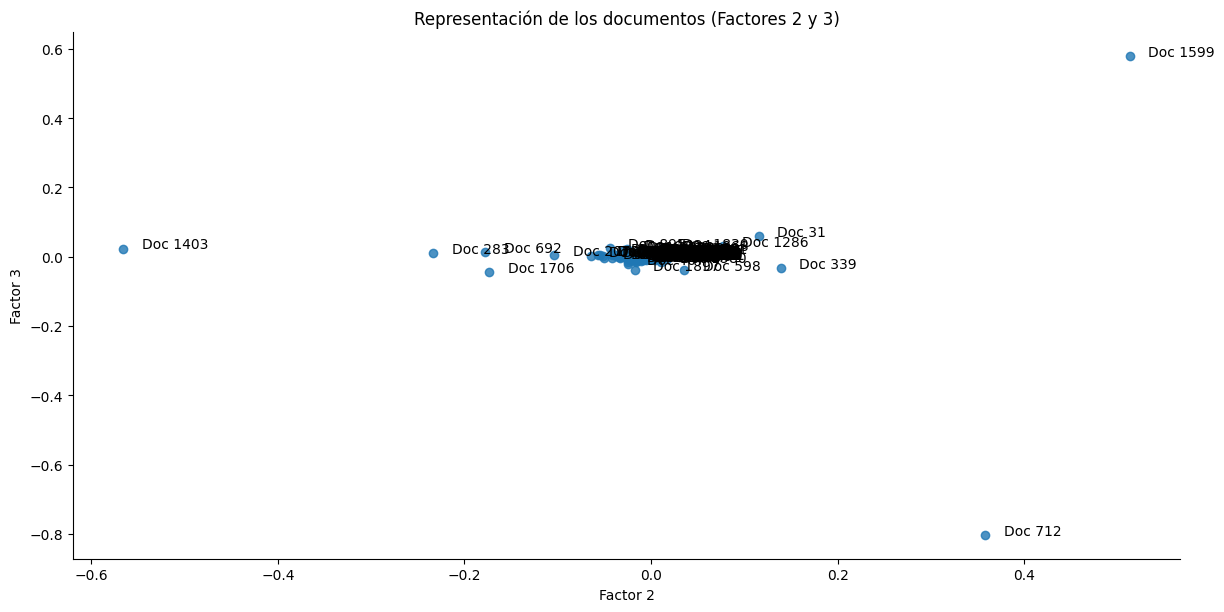

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({'f2': V_matrix[:, 1], 'f3': V_matrix[:, 2],
                   'group': ['Doc {}'.format(i+1) for i, doc in enumerate(documents)]})

sns.lmplot(data=df, x="f2", y="f3", fit_reg=False, height=6, aspect=2)

plt.title('Representación de los documentos (Factores 2 y 3)')
plt.xlabel('Factor 2')
plt.ylabel('Factor 3')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


label_point(df.f2, df.f3, df.group, plt.gca())


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


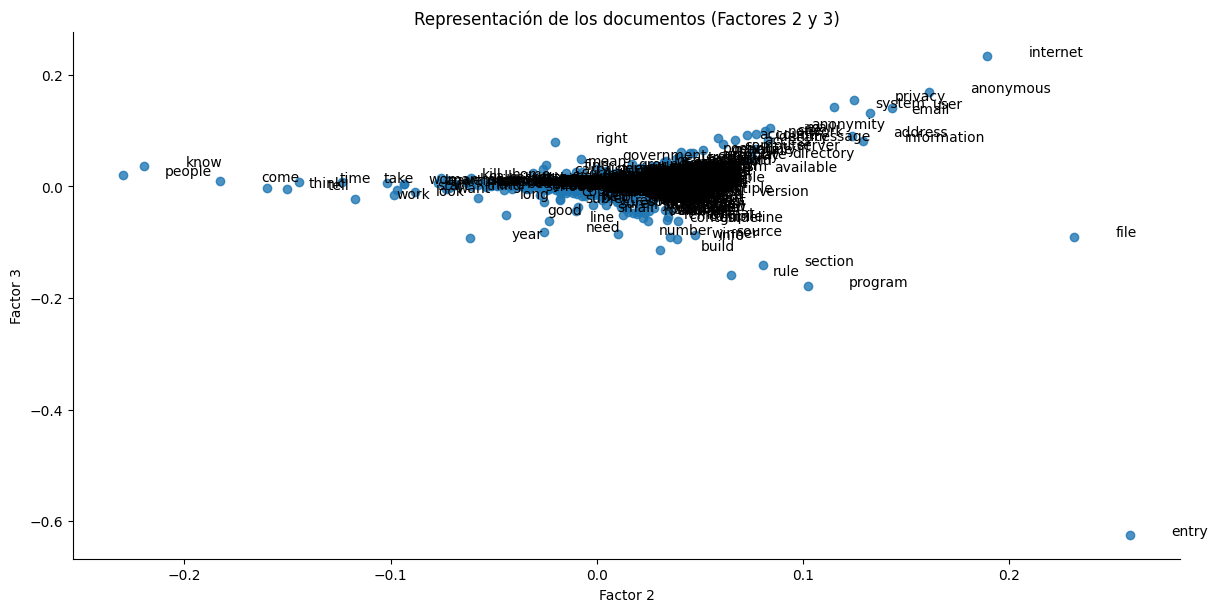

In [49]:
df = pd.DataFrame({'f2': U_matrix[:, 1], 'f3': U_matrix[:, 2],
                   'group': [word for word in dictionary.token2id.keys()]})

sns.lmplot(data=df, x="f2", y="f3", fit_reg=False, height=6, aspect=2)

plt.title('Representación de los documentos (Factores 2 y 3)')
plt.xlabel('Factor 2')
plt.ylabel('Factor 3')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


label_point(df.f2, df.f3, df.group, plt.gca())


Como se observa indica el grado de pertenencia por cada tema, y los valores mas grandes como entry, file, internet y anonymous tienen mas posibilidad de aparecer.

In [50]:
Lsi_model.print_topics()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.199*"file" + 0.196*"people" + 0.194*"entry" + 0.192*"know" + 0.173*"system" + 0.159*"program" + 0.145*"work" + 0.139*"internet" + 0.127*"time" + 0.126*"information"'),
 (1,
  '0.259*"entry" + 0.232*"file" + -0.230*"people" + -0.219*"know" + 0.189*"internet" + -0.183*"come" + 0.161*"anonymous" + -0.160*"think" + -0.150*"tell" + -0.145*"time"'),
 (2,
  '-0.624*"entry" + 0.234*"internet" + -0.179*"program" + 0.169*"anonymous" + -0.159*"rule" + 0.155*"privacy" + 0.142*"system" + -0.141*"section" + 0.140*"user" + 0.131*"email"'),
 (3,
  '0.275*"entry" + -0.219*"available" + -0.218*"version" + -0.196*"subject" + -0.186*"problem" + -0.180*"tape" + -0.156*"driver" + 0.153*"internet" + 0.145*"people" + -0.142*"work"'),
 (4,
  '0.360*"secret" + 0.282*"nuclear" + 0.258*"military" + 0.251*"ship" + 0.222*"naval" + 0.194*"plan" + 0.157*"attack" + 0.146*"fleet" + 0.127*"cartel" + -0.122*"people"'),
 (5,
  '-0.262*"available" + -0.203*"version" + 0.172*"drive" + 0.162*"driver" + 0.149*"tape"

# PUNTO 3

- Con los datos normalizados y vectorizados. ¿Es posible aplicar k-means?

Solo teniendo los datos normalizados y vectorizados no es posible aplicar el algoritmo de clasificación k-means, ya que este calcula distancias y no se puede establecer una distancia entre palabras, por ello, es necesario generar una matriz numérica que represente la información preprocesada, se aplicara TfidfVectorizer para cuantificar los datos.

- En caso de una respuesta afirmativa. Utilice alguno el método del codo, el método de la silueta, y el método GAP para determinar cuáles valores de $k$ (número de clusters) son sugeridos y aplique el modelo.

- Comparar resultados con los métodos anteriores: k-means, LDA y LSI.

- Concluya



In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
# usamos la funcion de Scikit para la hacer la bolsa de palabras TF-IDF
tfidf = TfidfVectorizer()
corpus_tfidf = tfidf.fit_transform(correo_clean)

# Resultados
print(tfidf.get_feature_names_out ())
print(corpus_tfidf.toarray())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['aalternate' 'aamazing' 'aangegeven' ... 'zure' 'zware' 'zwarte']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Utilizamos el criterio del codo para obtner el numero optimo de clusters.

In [57]:
def elbow_plot(df,n=2):
    """
        Función que plotea el número de cluster vs WCSS  buscando determinar el número de cluster óptimo.
        * Input: ---> df: pd.DataFrame con quien se ajusta el algoritmo k-means.
                ---> n (int): Número de cluster a comparar. Default 2.
        * Output: None

        ** Nota: Esta función depende de sklearn-KMeans y ploty_express***
    """
    from sklearn.cluster import KMeans
    import plotly.express as px
    inertias = [KMeans(n_clusters=k).fit(df).inertia_ for k in range(1,n+1)]
    data_plot = pd.DataFrame({"n_clusters":range(1,n+1),"WCSS":inertias})

    fig = px.line(data_plot, 
                  x="n_clusters", 
                  y = "WCSS", 
                  title = "Número óptimo de clusters",
                  template="plotly_white", 
                  markers=True)
    fig.update_xaxes(title_text = "Número de clusters")
    fig.update_yaxes(title_text = "WCSS: Within-Cluster Distance to Centroid")
    fig.show()
    return None

elbow_plot(corpus_tfidf,20)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Como se puede observar, en la grafica anterior, no es facil determinar el numero optimo clusters para el metodo de k-means, ya que, a pesar de que se probo primero con 25 grupos y luego con 50, buscando una estabilizacion de la grafica, sigue teniendo una pendiente bastante pronunciada, lo que significa que la varianza intra cluster no ha llegado a la minima y por lo tanto la funcion de minimos cuadrados aun no converge.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



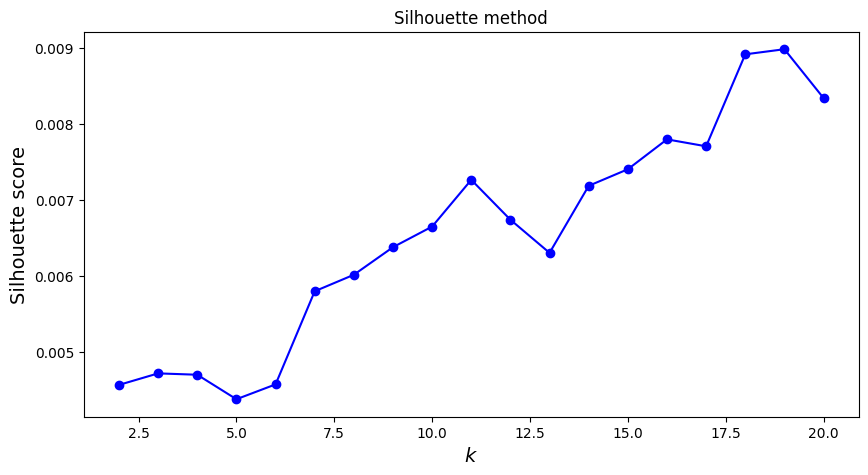

In [58]:
# se demora mucho, correr una sola vez 
def plot_silhouette(df,n=2, height = 5, width = 3):
  from sklearn.metrics import silhouette_score
  from sklearn.cluster import KMeans
  models = [KMeans(n_clusters=n).fit(df) for n in range(2,n+1)]
  silhouette_scores = [silhouette_score(df, model.labels_) for model in models]
  import matplotlib.pyplot as plt
  plt.figure(figsize=(width, height))
  plt.plot(list(range(2, n+1)), silhouette_scores, "bo-")
  plt.xlabel("$k$", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)
  plt.title("Silhouette method")
  plt.show()
  return None

plot_silhouette(corpus_tfidf, n=20, width = 10)

Para hacer una compracion justa entre los metodos, se calcula el numero optimo de clusters tambien para 50 grupos.
 

In [59]:
# Gap Statistic for K means
## Tomado de 
## https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number
## -of-clusters-in-python-898241e1d6ad
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: pd.DataFrame with the number of cluster and gap statistic.
    """
    from sklearn.cluster import KMeans
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape) 
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.mean(np.log(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)        
    return resultsdf


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-59-fe1f89b40ca0>:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:87

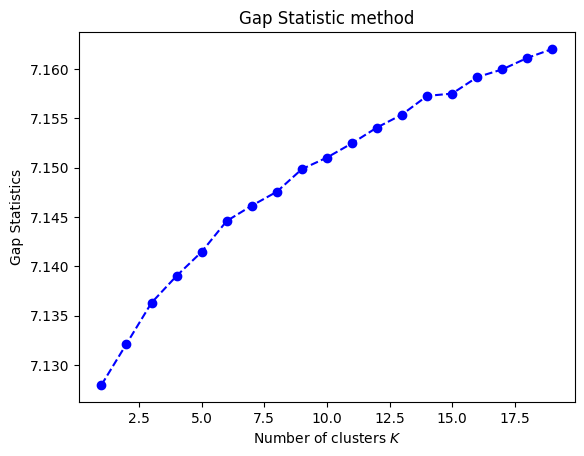

In [62]:
df1 = optimalK(corpus_tfidf, nrefs=2,maxClusters=20)
### Se demora un poco en graficar
plt.plot(df1["clusterCount"], df1["gap"], linestyle="--", marker="o", color="b")
plt.xlabel("Number of clusters $K$")
plt.title("Gap Statistic method")
plt.ylabel("Gap Statistics")
plt.show()

Si bien el criterio del codo no es muy claro de cuantos grupos se deben establecer para k-means, el coeficiente de siuleta, como se ve en la imagen, nos dice que el valor optimo es de 9, por lo que ese sera el numero clusters, pero como se debe hacer la comparacion entre los modelos de LDA y LSI se tomara el mismo numero de clusters que de topicos, es decir seran 20 clusters finales.

*Creación de k-means*

In [63]:
n = 20
kmeans = KMeans(n_clusters=n,                  ### Número de clusters
                random_state=0)                ### Semilla aleatoria.
kmeans.fit(corpus_tfidf)

#Revisamos los atributos, es decir, la inercia y los centroides.
## Atributos.
print(kmeans.inertia_)
print(kmeans.cluster_centers_)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



2342.781281426315
[[5.85126823e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


- Comparar resultados con los métodos anteriores: k-means, LDA y LSI.

K-means se utiliza para agrupar documentos según su similitud en términos de frecuencia de términos, mientras que LDA y LSI se utilizan para extraer información de tópicos y semántica latente de grandes conjuntos de datos de texto. K-means es rápido y fácil de implementar, pero requiere un número previo de grupos, mientras que LDA y LSI son útiles para descubrir patrones latentes en grandes conjuntos de datos, pero pueden ser computacionalmente costosos y pueden perder información importante debido a la reducción de dimensionalidad.

## Coherencia

In [67]:
import warnings
warnings.filterwarnings('ignore')
from gensim.models import CoherenceModel
from tqdm import tqdm

coherence = []
min_topics = 1
max_topics = 20
for num_topics in tqdm(range(min_topics, max_topics, 1)):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=0,
                         chunksize=100,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='u_mass')
    coherence.append(coherencemodel.get_coherence())

100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


In [68]:
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

,Coherence
Num Topics: 1,-1.330372
Num Topics: 2,-1.500981
Num Topics: 3,-1.684674
Num Topics: 4,-1.641210
Num Topics: 5,-1.940373
Num Topics: 6,-2.544356
Num Topics: 7,-2.801259
Num Topics: 8,-4.266235
Num Topics: 9,-5.281027
Num Topics: 10,-5.973503


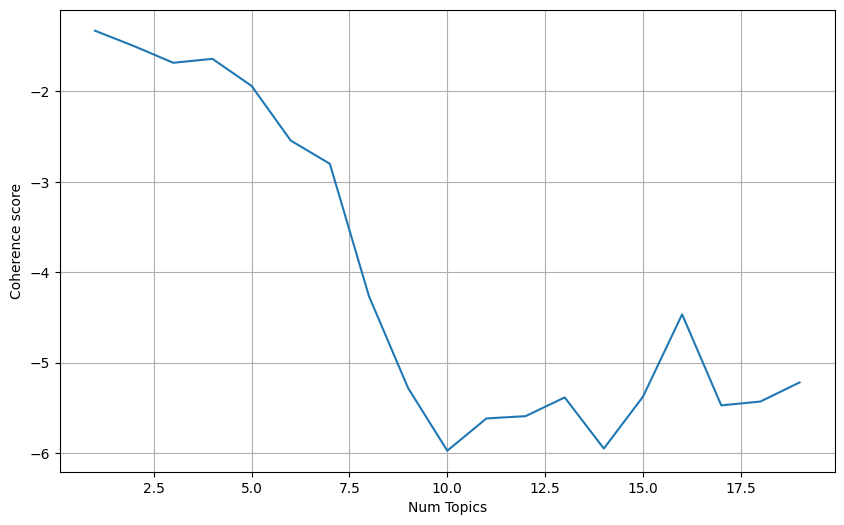

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()